# Getting additional bird data

`# Step 1. Retrieving data from eBird`

Go to  https://media.ebird.org/catalog?regionCode=AU&sort=rating_rank_desc&mediaType=audio.
- Replace the region code with your chosen region, e.g. US, GB, CA.
- Refer to the Alpha-2 codes [here](https://www.iban.com/country-codes) for the full list of options.

Click 'More Results' a bunch of times.

Right click on the page > 'Inspect' > 'Console' > Copy and paste the code from [`get_bird_images.js`](./crawlers/get_bird_images.js) into the Console > Run

Right-click on the output > 'Copy object' > Paste into a new file called `new_audio.json`.

Important: Your file MUST be called `new_audio.json` and it MUST be stored in the **same directory** as this notebook. 

`# Step 2. Convert to CSV`

In [24]:
! pip3 install jq

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [25]:
# Convert from a json to csv
! jq -r '.[] | [.alt, .cc, .src] | @csv' new_audio.json > new_audio.csv

`# Step 3. Merge wih existing data`

Should the new images be merged with an **existing** set of images?

If YES, ensure your existing images are stored as `images.csv` in the same directory as this notebook. Then uncomment and run the below cell.

If NO, skip to Step 4.

In [26]:
## Append existing images to new image file
## Important, this assumes the image file has a header, it excludes the first line of the existing images file when appending

#! awk 'FNR>1' images.csv >> new_images.csv

`# Step 5. Inspect`

In [27]:
# Import data into a dataframe for inspection
import pandas as pd
df_audio = pd.read_csv('new_audio.csv')
df_audio.columns = ["name", "cc", "audio_id"]
df_audio.sample(10)

,name,cc,audio_id
311,Black Swan,Zebedee Muller,255196561
574,Pacific Black Duck,David Secomb,524418541
733,Masked Lapwing (Black-shouldered),Tony Baylis,233554
434,Olive Whistler,Ged Tranter,114922551
141,Black Swan,Ramit Singal,265310771
592,Collared Sparrowhawk,Liam Murphy,412118721
805,Red-necked Avocet,Ken Tay,509478301
490,Welcome Swallow,Ramit Singal,261903431
346,Stubble Quail,Alfons Lawen,612649336
598,Osprey (Australasian),James Lambert,358875611


In [28]:
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      989 non-null    object
 1   cc        989 non-null    object
 2   audio_id  989 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 23.3+ KB


In [30]:
df_audio['split'] = df_audio['name'].str.split(' \(')[0]

In [34]:
df_audio[df_audio.name.str.contains(' \(')].tail()

,name,cc,audio_id,split
872,Australasian Figbird (flaviventris Group),James Lambert,610166097,"[Australasian Figbird, flaviventris Group)]"
897,Masked Lapwing (Black-shouldered),Alfons Lawen,489532611,"[Masked Lapwing, Black-shouldered)]"
919,Blue-faced Honeyeater (Blue-faced),Leonie Beaulieu,392619361,"[Blue-faced Honeyeater, Blue-faced)]"
944,Common Cicadabird (Slender-billed),James Lambert,273861571,"[Common Cicadabird, Slender-billed)]"
977,Gray Fantail (albiscapa),Ramit Singal,125284321,"[Gray Fantail, albiscapa)]"


In [ ]:
# Check number of bird calls
df_audio['name'].nunique()

TypeError: unhashable type: 'list'

In [ ]:
# inspect further into individual categories
df_images_plus_latest[df_images_plus_latest['category'] == 'songbird'].name.unique()

array(['Gray Shrikethrush', 'Golden Whistler', 'Olive Whistler',
       'Eastern Whipbird', 'Rufous Whistler', 'Chiming Wedgebill',
       'Chirruping Wedgebill', "Gilbert's Whistler"], dtype=object)

In [ ]:
# Check for duplicated images
df_images_plus_latest[df_images_plus_latest.image_id.duplicated()]

,name,cc,image_id,category


<Axes: ylabel='name'>

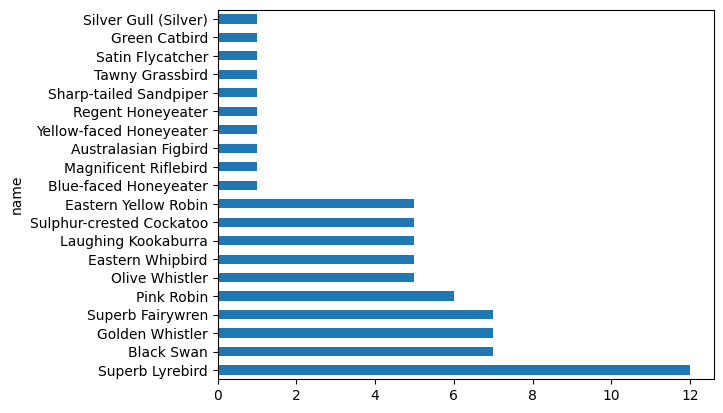

In [ ]:
# Check for species grouping - (too many to plot so just showing top and bottom 10)
pd.concat([df_images_plus_latest['name'].value_counts().head(10), df_images_plus_latest['name'].value_counts().tail(10)]).plot(kind='barh')

`# Step 6. Optional Extra Cleaning`

In [ ]:
# Cut back over-indexed birds

vc = df_images_plus_latest.name.value_counts()
overindexed_species = df_images_plus_latest.name.value_counts()[vc > 10]

print(f'The median number of images per species is {vc.median()}')
print(f'{overindexed_species.count()} species have more than 10 images')
print(f'They are: \n {overindexed_species}')

The median number of images per species is 1.0
1 species have more than 10 images
They are: 
 name
Superb Lyrebird    12
Name: count, dtype: int64


In [ ]:
# Reduce max images per species to 10

df_images_plus_latest['row_num'] = df_images_plus_latest.sort_values(['name', 'image_id'], ascending=True).groupby(['name', 'category']).cumcount() + 1
df_reduced = df_images_plus_latest[df_images_plus_latest.row_num <= 10]

df_reduced[['name','image_id','cc','category']].to_csv('new_images_categorised_reduced.csv', index=False)

<Axes: ylabel='category'>

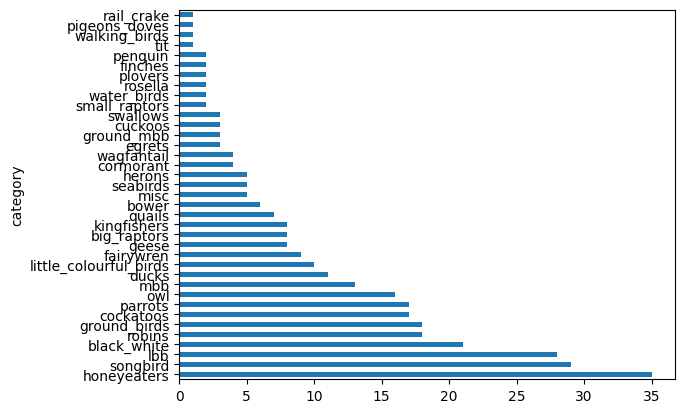

In [ ]:
# Check distribution of grouping
df_reduced['category'].value_counts().plot(kind='barh')

# Done! 🎉

Your fresh twitch or tweek images are ready to go